In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import time
PROJECT_TIME = time.asctime()
PROJECT_TIME

'Wed Jul 14 14:13:05 2021'

In [3]:
!pip install transformers

     |████████████████████████████████| 2.5MB 29.4MB/s 
     |████████████████████████████████| 3.3MB 49.3MB/s 
     |████████████████████████████████| 901kB 44.1MB/s 


In [4]:
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import random
import time
import datetime

In [5]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [6]:
!git clone https://github.com/perfume-reconmendation/topic_modeling.git

Cloning into 'topic_modeling'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 20 (delta 7), reused 16 (delta 5), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [7]:
df = pd.read_csv('/content/topic_modeling/data/final_data.csv')
df = df.dropna().reset_index().drop(['index'], axis=1)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   gender   75000 non-null  object
 1   name     75000 non-null  object
 2   accords  75000 non-null  object
 3   review   75000 non-null  object
dtypes: object(4)
memory usage: 2.3+ MB


,gender,name,accords,review
0,female,Alien Mugler for women,"['white floral', 'amber', 'woody']","Got a sample of this today, and my 9 year old ..."
1,female,Alien Mugler for women,"['white floral', 'amber', 'woody']",First impressions. Test on blotter.\nI have he...
2,female,Alien Mugler for women,"['white floral', 'amber', 'woody']",This perfume reminds me of my best friend. Act...
3,female,Alien Mugler for women,"['white floral', 'amber', 'woody']",Imagine tripping over your own feet and fallin...
4,female,Alien Mugler for women,"['white floral', 'amber', 'woody']",Gorgeous Gorgeous Blend ..\nLove the scent...\...


In [8]:
len(df['name'].unique())

89

In [9]:
df_label = pd.read_csv('/content/topic_modeling/data/labeled_data.csv', usecols=['name', 'label'])
df_label = df_label.dropna().reset_index().drop(['index'], axis=1)
df_label.info()
df_label.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    89 non-null     object 
 1   label   89 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


,name,label
0,Alien Mugler for women,2.0
1,Coco Mademoiselle Chanel for women,2.0
2,Black Orchid Tom Ford for women,2.0
3,Black Opium Yves Saint Laurent for women,2.0
4,Hypnotic Poison Christian Dior for women,2.0


In [10]:
df_label.label = df_label.label.astype(int)
df_label

,name,label
0,Alien Mugler for women,2
1,Coco Mademoiselle Chanel for women,2
2,Black Orchid Tom Ford for women,2
3,Black Opium Yves Saint Laurent for women,2
4,Hypnotic Poison Christian Dior for women,2
...,...,...
84,Spicebomb Extreme Viktor&Rolf for men,1
85,Cool Water Davidoff for men,0
86,Herod Parfums de Marly for men,1
87,L’Homme Ideal Eau de Parfum Guerlain for men,1


In [11]:
len(df_label['label'].unique())

4

In [12]:
train_df = pd.merge(df, df_label, how='inner', on='name')
train_df

,gender,name,accords,review,label
0,female,Alien Mugler for women,"['white floral', 'amber', 'woody']","Got a sample of this today, and my 9 year old ...",2
1,female,Alien Mugler for women,"['white floral', 'amber', 'woody']",First impressions. Test on blotter.\nI have he...,2
2,female,Alien Mugler for women,"['white floral', 'amber', 'woody']",This perfume reminds me of my best friend. Act...,2
3,female,Alien Mugler for women,"['white floral', 'amber', 'woody']",Imagine tripping over your own feet and fallin...,2
4,female,Alien Mugler for women,"['white floral', 'amber', 'woody']",Gorgeous Gorgeous Blend ..\nLove the scent...\...,2
...,...,...,...,...,...
74995,male,Jazz Club Maison Martin Margiela for men,"['tobacco', 'rum', 'sweet', 'vanilla', 'woody'...",I've been wanting to try this on for a while a...,1
74996,male,Jazz Club Maison Martin Margiela for men,"['tobacco', 'rum', 'sweet', 'vanilla', 'woody'...",Goes on sweet. Sweet and boozy with too much d...,1
74997,male,Jazz Club Maison Martin Margiela for men,"['tobacco', 'rum', 'sweet', 'vanilla', 'woody'...",Yesterday I walked in to a store looking for a...,1
74998,male,Jazz Club Maison Martin Margiela for men,"['tobacco', 'rum', 'sweet', 'vanilla', 'woody'...",Tried this today and now looking at notes I c...,1


In [19]:
# 셔플
shuffle = train_df.sample(frac=1)

# data
train = shuffle.reset_index(drop=True)

# 토큰 사전
document_bert = ["[CLS] " + str(s) + " [SEP]" for s in train.review]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(s) for s in document_bert]

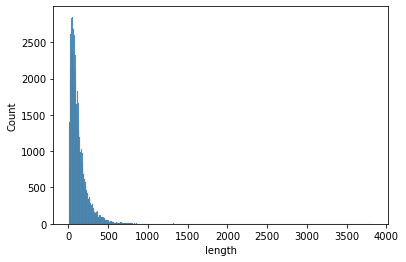

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

arr  = [len(t) for t in tokenized_texts]
v_df = pd.DataFrame(arr, columns=['length'])
sns.histplot(v_df['length'])
plt.show()

In [40]:
# 패딩
MAX_LEN = 256
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

# 성능을 위한 마스킹
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [41]:
# Validation split
train_inputs, validation_inputs, train_labels, validation_labels = \
    train_test_split(input_ids, train['label'].values, random_state=1, test_size=0.1)
train_masks, validation_masks, _, _ = \
    train_test_split(attention_masks, input_ids, random_state=1, test_size=0.1)

In [42]:
# To Tensor
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [43]:
# To Loader
BATCH_SIZE = 8

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [44]:
train_inputs.shape, train_labels.shape, train_masks.shape

(torch.Size([67500, 256]), torch.Size([67500]), torch.Size([67500, 256]))

In [45]:
validation_inputs.shape, validation_labels.shape, validation_masks.shape

(torch.Size([7500, 256]), torch.Size([7500]), torch.Size([7500, 256]))

In [46]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [47]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [48]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [49]:
import gc
gc.collect()

454

In [50]:
model.save_pretrained("/content/drive/MyDrive/SAI/p/lunab_model_21_07_14")
tokenizer.save_pretrained("/content/drive/MyDrive/SAI/p/lunab_tokenizer_21_07_14")

('/content/drive/MyDrive/SAI/p/lunab_tokenizer_21_07_14/tokenizer_config.json',
 '/content/drive/MyDrive/SAI/p/lunab_tokenizer_21_07_14/special_tokens_map.json',
 '/content/drive/MyDrive/SAI/p/lunab_tokenizer_21_07_14/vocab.txt',
 '/content/drive/MyDrive/SAI/p/lunab_tokenizer_21_07_14/added_tokens.json')

In [51]:
# 재현을 위해 랜덤시드 고정
seed_val = 1
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# cuda delete cache
torch.cuda.empty_cache()

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(tqdm(train_dataloader, desc='[Train] ')):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in tqdm(validation_dataloader, desc="[Validation]"):
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    model.save_pretrained("/content/drive/MyDrive/SAI/p/lunab_model_21_07_14_"+str(epoch_i))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...


  Batch   500  of  8,438.    Elapsed: 0:03:15.
  Batch 1,000  of  8,438.    Elapsed: 0:06:40.
  Batch 1,500  of  8,438.    Elapsed: 0:10:05.
  Batch 2,000  of  8,438.    Elapsed: 0:13:30.
  Batch 2,500  of  8,438.    Elapsed: 0:16:54.
  Batch 3,000  of  8,438.    Elapsed: 0:20:19.
  Batch 3,500  of  8,438.    Elapsed: 0:23:44.
  Batch 4,000  of  8,438.    Elapsed: 0:27:08.
  Batch 4,500  of  8,438.    Elapsed: 0:30:33.
  Batch 5,000  of  8,438.    Elapsed: 0:33:57.
  Batch 5,500  of  8,438.    Elapsed: 0:37:22.
  Batch 6,000  of  8,438.    Elapsed: 0:40:47.
  Batch 6,500  of  8,438.    Elapsed: 0:44:11.
  Batch 7,000  of  8,438.    Elapsed: 0:47:36.
  Batch 7,500  of  8,438.    Elapsed: 0:51:00.
  Batch 8,000  of  8,438.    Elapsed: 0:54:25.


  Average training loss: 0.61
  Training epcoh took: 0:57:24

Running Validation...



  Accuracy: 0.81
  Validation took: 0:02:14

======== Epoch 2 / 3 ========
Training...


  Batch   500  of  8,438.    Elapsed: 0:03:25.
  Batch 1,000  of  8,438.    Elapsed: 0:06:50.
  Batch 1,500  of  8,438.    Elapsed: 0:10:14.
  Batch 2,000  of  8,438.    Elapsed: 0:13:38.
  Batch 2,500  of  8,438.    Elapsed: 0:17:03.
  Batch 3,000  of  8,438.    Elapsed: 0:20:28.
  Batch 3,500  of  8,438.    Elapsed: 0:23:53.
  Batch 4,000  of  8,438.    Elapsed: 0:27:17.
  Batch 4,500  of  8,438.    Elapsed: 0:30:42.
  Batch 5,000  of  8,438.    Elapsed: 0:34:07.
  Batch 5,500  of  8,438.    Elapsed: 0:37:32.
  Batch 6,000  of  8,438.    Elapsed: 0:40:57.
  Batch 6,500  of  8,438.    Elapsed: 0:44:21.
  Batch 7,000  of  8,438.    Elapsed: 0:47:46.
  Batch 7,500  of  8,438.    Elapsed: 0:51:11.
  Batch 8,000  of  8,438.    Elapsed: 0:54:36.


  Average training loss: 0.41
  Training epcoh took: 0:57:35

Running Validation...



  Accuracy: 0.83
  Validation took: 0:02:14

======== Epoch 3 / 3 ========
Training...


  Batch   500  of  8,438.    Elapsed: 0:03:25.
  Batch 1,000  of  8,438.    Elapsed: 0:06:49.
  Batch 1,500  of  8,438.    Elapsed: 0:10:14.
  Batch 2,000  of  8,438.    Elapsed: 0:13:38.
  Batch 2,500  of  8,438.    Elapsed: 0:17:02.
  Batch 3,000  of  8,438.    Elapsed: 0:20:27.
  Batch 3,500  of  8,438.    Elapsed: 0:23:51.
  Batch 4,000  of  8,438.    Elapsed: 0:27:16.
  Batch 4,500  of  8,438.    Elapsed: 0:30:41.
  Batch 5,000  of  8,438.    Elapsed: 0:34:05.
  Batch 5,500  of  8,438.    Elapsed: 0:37:30.
  Batch 6,000  of  8,438.    Elapsed: 0:40:54.
  Batch 6,500  of  8,438.    Elapsed: 0:44:19.
  Batch 7,000  of  8,438.    Elapsed: 0:47:43.
  Batch 7,500  of  8,438.    Elapsed: 0:51:08.
  Batch 8,000  of  8,438.    Elapsed: 0:54:33.


  Average training loss: 0.28
  Training epcoh took: 0:57:32

Running Validation...



  Accuracy: 0.82
  Validation took: 0:02:14

Training complete!


In [1]:
def evaluate(e_model, e_tokenizer, text):
    e_model.cuda()
    e_model.eval()

    m = {
        0: 'A type',
        1: 'B type',
        2: 'C type',
        3: 'D type'
    }

    sentence = text
    sentences = ["[CLS] " + sentence + " [SEP]"]

    tokenized_texts = [e_tokenizer.tokenize(sent) for sent in sentences]

    input_ids = [e_tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    test_inputs = torch.tensor(input_ids).to(device)
    test_masks = torch.tensor(attention_masks).to(device)

    outputs = e_model(test_inputs, token_type_ids=None, attention_mask=test_masks)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    print('this text predicted :', m[logits.argmax(1)[0]])

In [ ]:
evaluate(model, tokenizer, "i feel the wind while looking at the night sky in summer.")
evaluate(model, tokenizer, "it's like having a strong spice in your mouth.")

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

model.save_pretrained("/content/drive/MyDrive/SAI/p/lunab_model_21_06_30")
tokenizer.save_pretrained("/content/drive/MyDrive/SAI/p/lunab_tokenizer_21_06_30")

print('Done...')

Done...


In [ ]:
load_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/SAI/p/lunab_model_21_06_30")
load_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/SAI/p/lunab_tokenizer_21_06_30")

print('Load...')

Load...


In [ ]:
evaluate(load_model, load_tokenizer, "i feel the wind while looking at the night sky in summer.")
evaluate(load_model, load_tokenizer, "it's like having a strong spice in your mouth.")

this text predicted : A type
this text predicted : C type
